# 一、前言

今天是第10天，我们将使用LSTM完成股票开盘价格的预测，最后的R2可达到`0.74`，相对传统的RNN的`0.72`提高了两个百分点。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1ojOSS8I7F4E_uoPBq0HTUg （提取码：94ho）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

# 二、LSTM的是什么

**神经网络程序的基本流程**

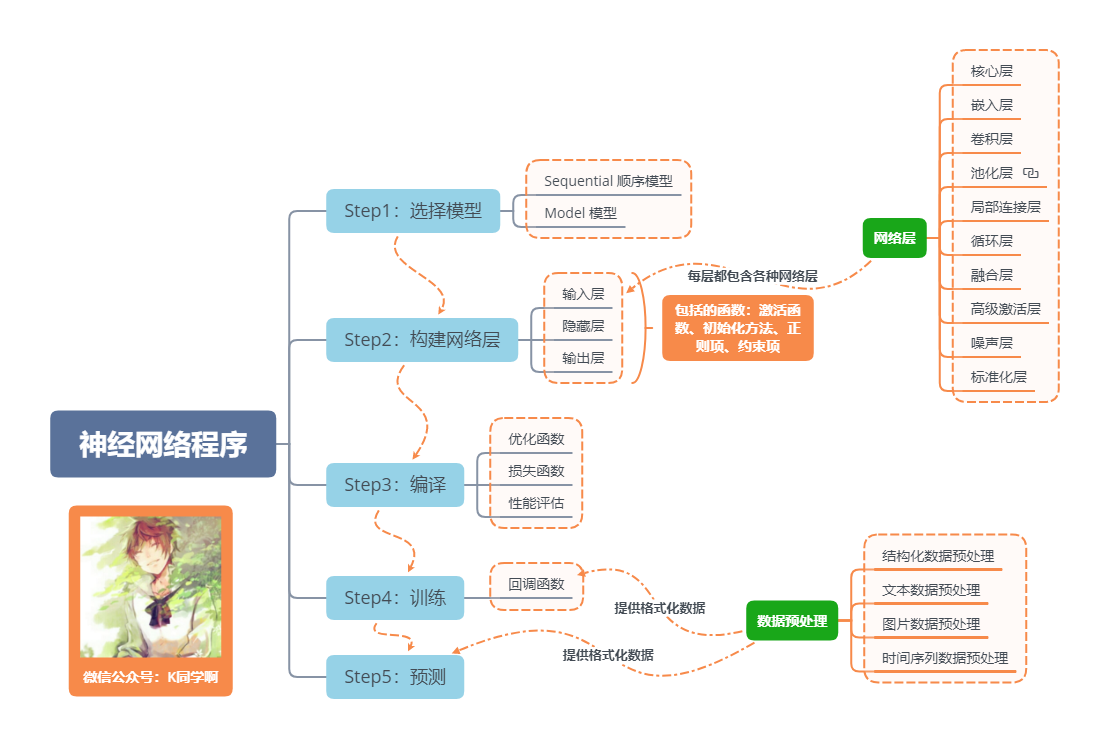

一句话介绍LSTM，**它是RNN的进阶版，如果说RNN的最大限度是理解一句话，那么LSTM的最大限度则是理解一段话**，详细介绍如下：

LSTM，全称为长短期记忆网络(Long Short Term Memory networks)，是一种特殊的RNN，能够学习到长期依赖关系。LSTM由Hochreiter & Schmidhuber (1997)提出，许多研究者进行了一系列的工作对其改进并使之发扬光大。LSTM在许多问题上效果非常好，现在被广泛使用。

所有的循环神经网络都有着重复的神经网络模块形成链的形式。在普通的RNN中，重复模块结构非常简单，其结构如下：

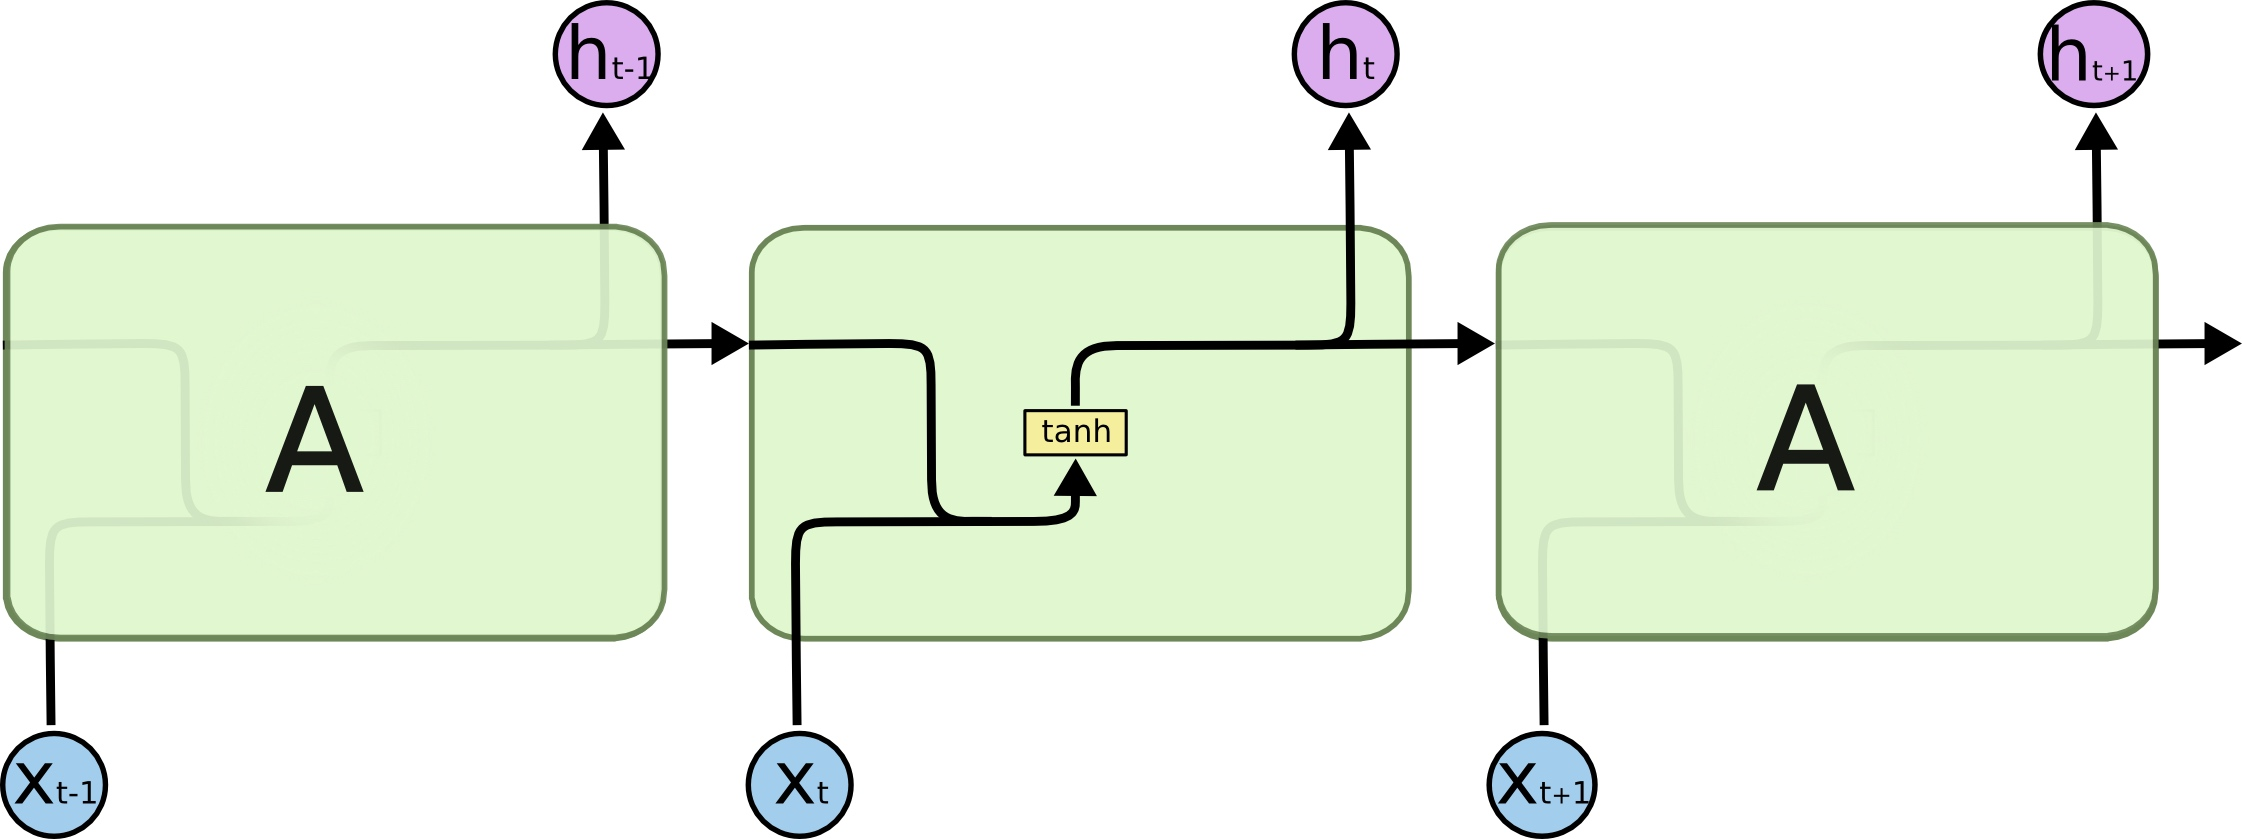

LSTM避免了长期依赖的问题。可以记住长期信息！LSTM内部有较为复杂的结构。能通过门控状态来选择调整传输的信息，**记住需要长时间记忆的信息，忘记不重要的信息**，其结构如下：

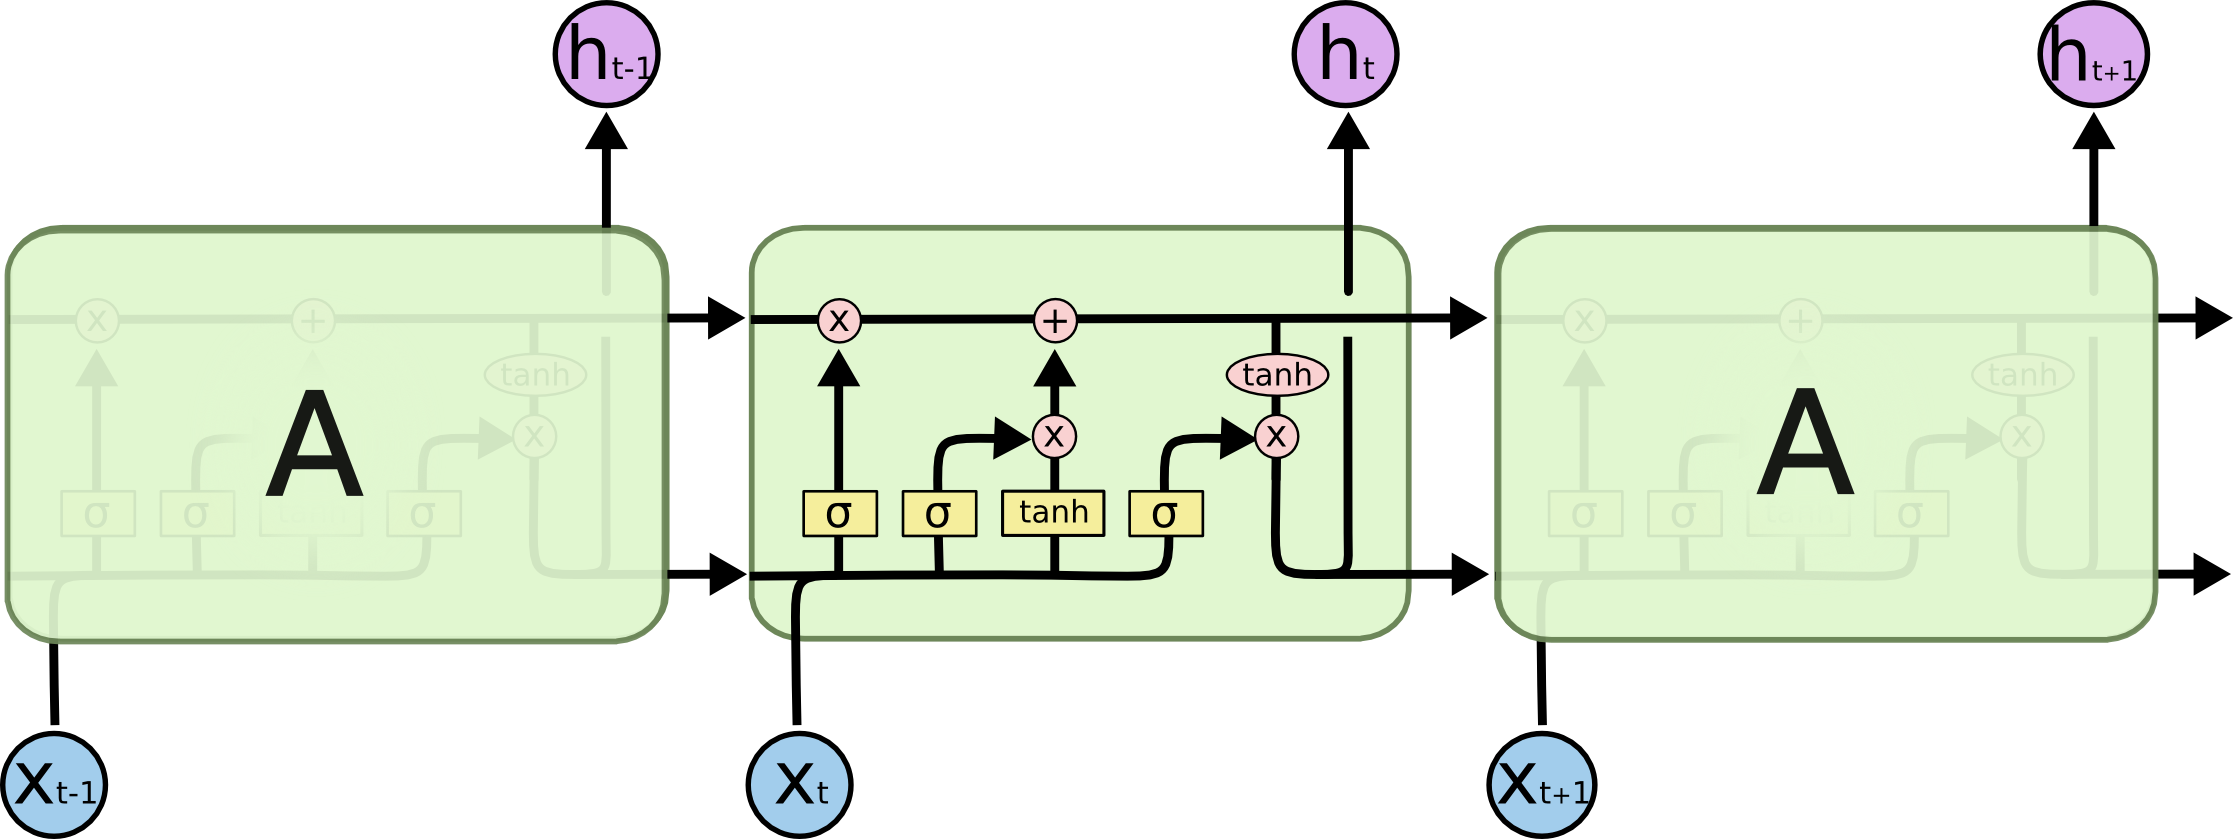

# 三、准备工作

## 1.设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2.设置相关参数

In [2]:
import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models          import Sequential
from keras.layers          import Dense,LSTM,Bidirectional


# 确保结果尽可能重现
from numpy.random          import seed
seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 40    # 时间戳
n_epochs     = 20    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 1

## 3.加载数据

In [3]:
data = pd.read_csv('./datasets/SH600519.csv')  # 读取股票文件

data

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519
...,...,...,...,...,...,...,...,...
2421,2495,2020-04-20,1221.000,1227.300,1231.500,1216.800,24239.00,600519
2422,2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2423,2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2424,2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519


In [4]:
"""
前(2426-300=2126)天的开盘价作为训练集,后300天的开盘价作为测试集
"""
training_set = data.iloc[0:2426 - 300, 2:3].values  
test_set     = data.iloc[2426 - 300:, 2:3].values

# 四、数据预处理

## 1.归一化

In [5]:
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 

## 2.时间戳函数

In [6]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 五、构建模型 

In [7]:
# 建构 LSTM模型
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    
model.summary() # 输出模型结构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


# 六、激活模型

In [8]:
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

# 七、训练模型

In [9]:
history = model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=n_epochs, 
                    validation_data=(X_test, y_test), 
                    validation_freq=1)                  #测试的epoch间隔数

model.summary()

Epoch 1/20
33/33 [==============================] - 5s 107ms/step - loss: 0.1049 - val_loss: 0.0569
Epoch 2/20
33/33 [==============================] - 3s 86ms/step - loss: 0.0074 - val_loss: 1.1616
Epoch 3/20
33/33 [==============================] - 3s 83ms/step - loss: 0.0012 - val_loss: 0.1408
Epoch 4/20
33/33 [==============================] - 3s 78ms/step - loss: 5.8758e-04 - val_loss: 0.0421
Epoch 5/20
33/33 [==============================] - 3s 84ms/step - loss: 5.3411e-04 - val_loss: 0.0159
Epoch 6/20
33/33 [==============================] - 3s 81ms/step - loss: 3.9690e-04 - val_loss: 0.0034
Epoch 7/20
33/33 [==============================] - 3s 84ms/step - loss: 4.3521e-04 - val_loss: 0.0032
Epoch 8/20
33/33 [==============================] - 3s 85ms/step - loss: 3.8233e-04 - val_loss: 0.0059
Epoch 9/20
33/33 [==============================] - 3s 81ms/step - loss: 3.6539e-04 - val_loss: 0.0082
Epoch 10/20
33/33 [==============================] - 3s 81ms/step - loss: 3.1790e-04

# 八、结果可视化

## 1.绘制loss图

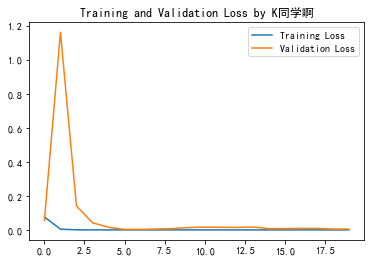

In [10]:
plt.plot(history.history['loss']    , label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss by K同学啊')
plt.legend()
plt.show()

## 2.预测

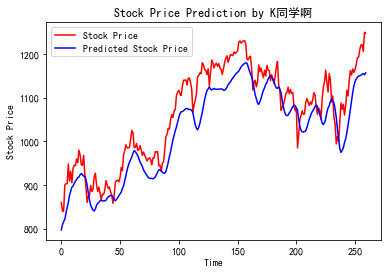

In [11]:
predicted_stock_price = model.predict(X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price      = sc.inverse_transform(y_test)# 对真实数据还原---从（0，1）反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction by K同学啊')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## 3.评估

In [12]:
"""
MSE  ：均方误差    ----->  预测值减真实值求平方后求均值
RMSE ：均方根误差  ----->  对均方误差开方
MAE  ：平均绝对误差----->  预测值减真实值求绝对值后求均值
R2   ：决定系数，可以简单理解为反映模型拟合优度的重要的统计量

详细介绍可以参考文章：https://blog.csdn.net/qq_38251616/article/details/107997435
"""
MSE   = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE  = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE   = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2    = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 2688.75170
均方根误差: 51.85317
平均绝对误差: 44.97829
R2: 0.74036


拟合度除了更换模型外，还可以调整参数来提高，这里主要是介绍LSTM，就不对调参做详细介绍了。